# Planning a Ligand Network

A [Ligand Network] is a graph of transformations between small molecules, typically such that every small molecule can reach every other small molecule via a series of transformations. This eventually forms the graph of the free energy campaign. A `LigandNetwork` can be generated from a collection of `SmallMoleculeComponent` instances by optimising over possible networks according to some criteria; in OpenFE, this involves combining a network generating strategy with a scoring function for individual mappings.

[Ligand Network]: https://docs.openfree.energy/en/stable/reference/api/generated/openfe.setup.LigandNetwork.html

## Setup

In [1]:
%matplotlib inline

from rdkit import Chem
from openmm import unit

import openfe

This cookbook assumes you've already loaded a collection of `SmallMoleculeComponent` objects into an iterable called `ligands`. For more information, see [Loading Small Molecules]:

[Loading Small Molecules]: https://docs.openfree.energy/en/stable/cookbook/loading_molecules.html#loading-small-molecules

In [2]:
ligands = [
    openfe.SmallMoleculeComponent(mol) 
    for mol in Chem.SDMolSupplier(
        "assets/somebenzenes.sdf", 
        removeHs=False,
    )
]

## Choose an atom mapper

An atom mapper produces mappings between two given ligands. Atom mapper classes inherit from [LigandAtomMapper]. Each atom mapper suggests one or more mappings, which can be scored seperately. As a result, multiple atom mappers can be used to generate additional mappings for network planning.

[LigandAtomMapper]: https://docs.openfree.energy/en/stable/reference/api/generated/openfe.setup.atom_mapping.LigandAtomMapper.html

In [3]:
mappers = [
    openfe.setup.LomapAtomMapper(
        time=20, # Time out if MCS algorithm takes 20 seconds
        threed=True, # Use atom positions to prune symmetric mappings
        max3d=1.0, # Forbid mapping between atoms more than 1.0 Å apart
        element_change=True, # Allow mappings that change an atoms element
        seed='', # Empty SMARTS string causes MCS search to start from scratch
        shift=False, # Keep pre-aligned atom positions for 3D position checks
    ),
    # openfe.setup.PersesAtomMapper(
    #     allow_ring_breaking=True, # Propose mappings that break cyclic systems
    #     preserve_chirality=True, # Forbid mappings that change stereochemistry
    #     use_positions=True, # Use atom positions rather than MCS to choose mappings
    #     coordinate_tolerance=0.25 * unit.angstrom, # Forbid mappings between distant atoms
    # ),
]

## Choose a scoring function

Many ligand network planners require some way to score each possible network so that the optimal network can be identified. OpenFE scores networks by the quality of the mappings between ligands - transformations that are expected to converge quickly without introducing artifacts are scored highly, and more drastic or risky alchemy is penalised. A scoring function is a function that takes an atom mapping and returns a float between 0.0 and 1.0, with higher numbers representing better maps.

In [4]:
# The product of other LOMAP scorers
scorer = openfe.lomap_scorers.default_lomap_score 

# # The default PERSES scoring function
# scorer = openfe.perses_scorers.default_perses_score 

# # Or define your own scoring function
# scorer = lambda m: (
#     openfe.lomap_scorers.default_lomap_score(m) 
#     * openfe.perses_scorers.default_perses_scorer(m)
# )

## Plan the network

Finally, pass the ligands, mapper and scorer to a planner to generate the network. A planner takes these three arguments (and perhaps some more) and returns a `LigandNetwork`. Each planner implements a particular strategy for structuring a network. Different strategies may balance the precision-performance trade-off differently, provide edge redundancy for troubleshooting, or be more or less appropriate for a given set of ligands:

In [5]:
# Choose the network that minimises the sum of scores
ligand_network = openfe.ligand_network_planning.generate_minimal_spanning_network(
    ligands=ligands,
    mappers=mappers,
    scorer=scorer,
)

# # Choose the lomap network that adds some closed ligand cycles
# ligand_network = openfe.ligand_network_planning.generate_lomap_network(
#     molecules=ligands,
#     mappers=mappers,
#     scorer=scorer,
# )

# # Connect each ligand to a central ligand
# ligand_network = openfe.ligand_network_planning.generate_radial_network(
#     ligands=ligands[1:],
#     central_ligand=ligands[0],
#     mappers=mappers,
#     scorer=scorer,
# )

## Visualize

For more ways to visualize a `LigandNetwork`, see [Visualizing Ligand Networks].

[Visualizing Ligand Networks]: https://docs.openfree.energy/en/stable/cookbook/ligandnetwork_vis.html

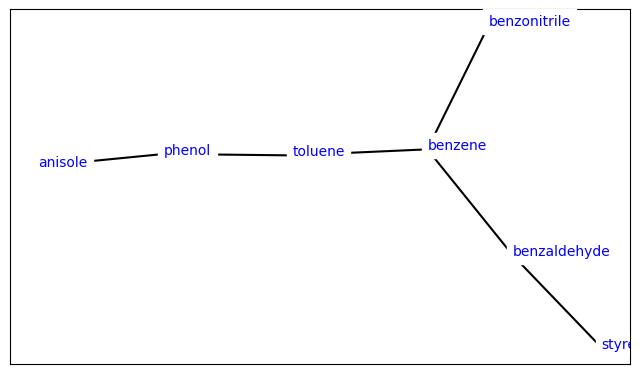

In [6]:
from openfe.utils.atommapping_network_plotting import plot_atommapping_network

plot_atommapping_network(ligand_network)